In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pspy import so_dict, pspy_utils
from pspipe_utils import pspipe_list

In [2]:
# mnms_dir = Path("/pscratch/sd/x/xgarrido/analysis/act/products/dr6/mnms/")
base_dir = Path("/pscratch/sd/x/xzackli/PSpipe/project/data_analysis/")
param_dict_file = base_dir / "paramfiles" / "global_dr6_v4.dict"
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]

d = so_dict.so_dict()
d.read_from_file(param_dict_file)
lmax = d["lmax"]
binning_file = d["binning_file"]
spec_list = pspipe_list.get_spec_name_list(d, delimiter="_")  # unrolled fields
bin_lo, bin_hi, lb, bin_size = pspy_utils.read_binning_file(binning_file, lmax)
n_spec = len(spectra)
n_bins = len(lb)  # number of bins is same for all spectra in block

In [3]:
# na, nb are each i.e. 'dr6_pa6_f150'
spec1 = spec_list[-1]
na, nb = spec1.split("x")
print(na, nb)

dr6_pa6_f150 dr6_pa6_f150


The operator $T(n_a, n_b)$ is defined as the linear operator which takes a pseudo-spectrum of some polarizations between two arrays $n_a$ and $n_b$ (in dr6, this operator is independent of split) and outputs a measured spectrum.

All operators start from $\ell = 2$.

$$
T_{bl'} =  F_{bb}^{-1} P_{bl} M_{ll'}^{-1} 
$$
where $F_{bb}^{-1}$ corrects for the $k$-space filter, $P_{bl}$ is the binning operator, and $M_{ll'}^{-1}$ is the unbinned inverse mode-coupling matrix.

* Fbb is missing the TE components, should check what the code is doing (it's impossible to include at present)
* Mll is a gigantic matrix, is it desirable to break it up? (yes) we need to assemble the TT and EE blocks, as an example
* binning operator is block diagonal

In [4]:
l = np.arange(2, lmax)
cltype = "Dl"
if cltype == "Dl": fac = (l * (l + 1) / (2 * np.pi))
elif cltype == "Cl": fac = l * 0 + 1
Pbl = np.zeros( (n_bins, lmax) )
for ibin in range(n_bins):
    loc = np.where((l >= bin_lo[ibin]) & (l <= bin_hi[ibin]))[0]
    # ps[ibin] = (cl[loc] * fac[loc]).mean()
    Pbl[ibin,loc] = fac[loc] / len(loc)
Pbl = Pbl[:,2:lmax]  # cut at ell = 2
# plt.imshow(Pbl, aspect=100)

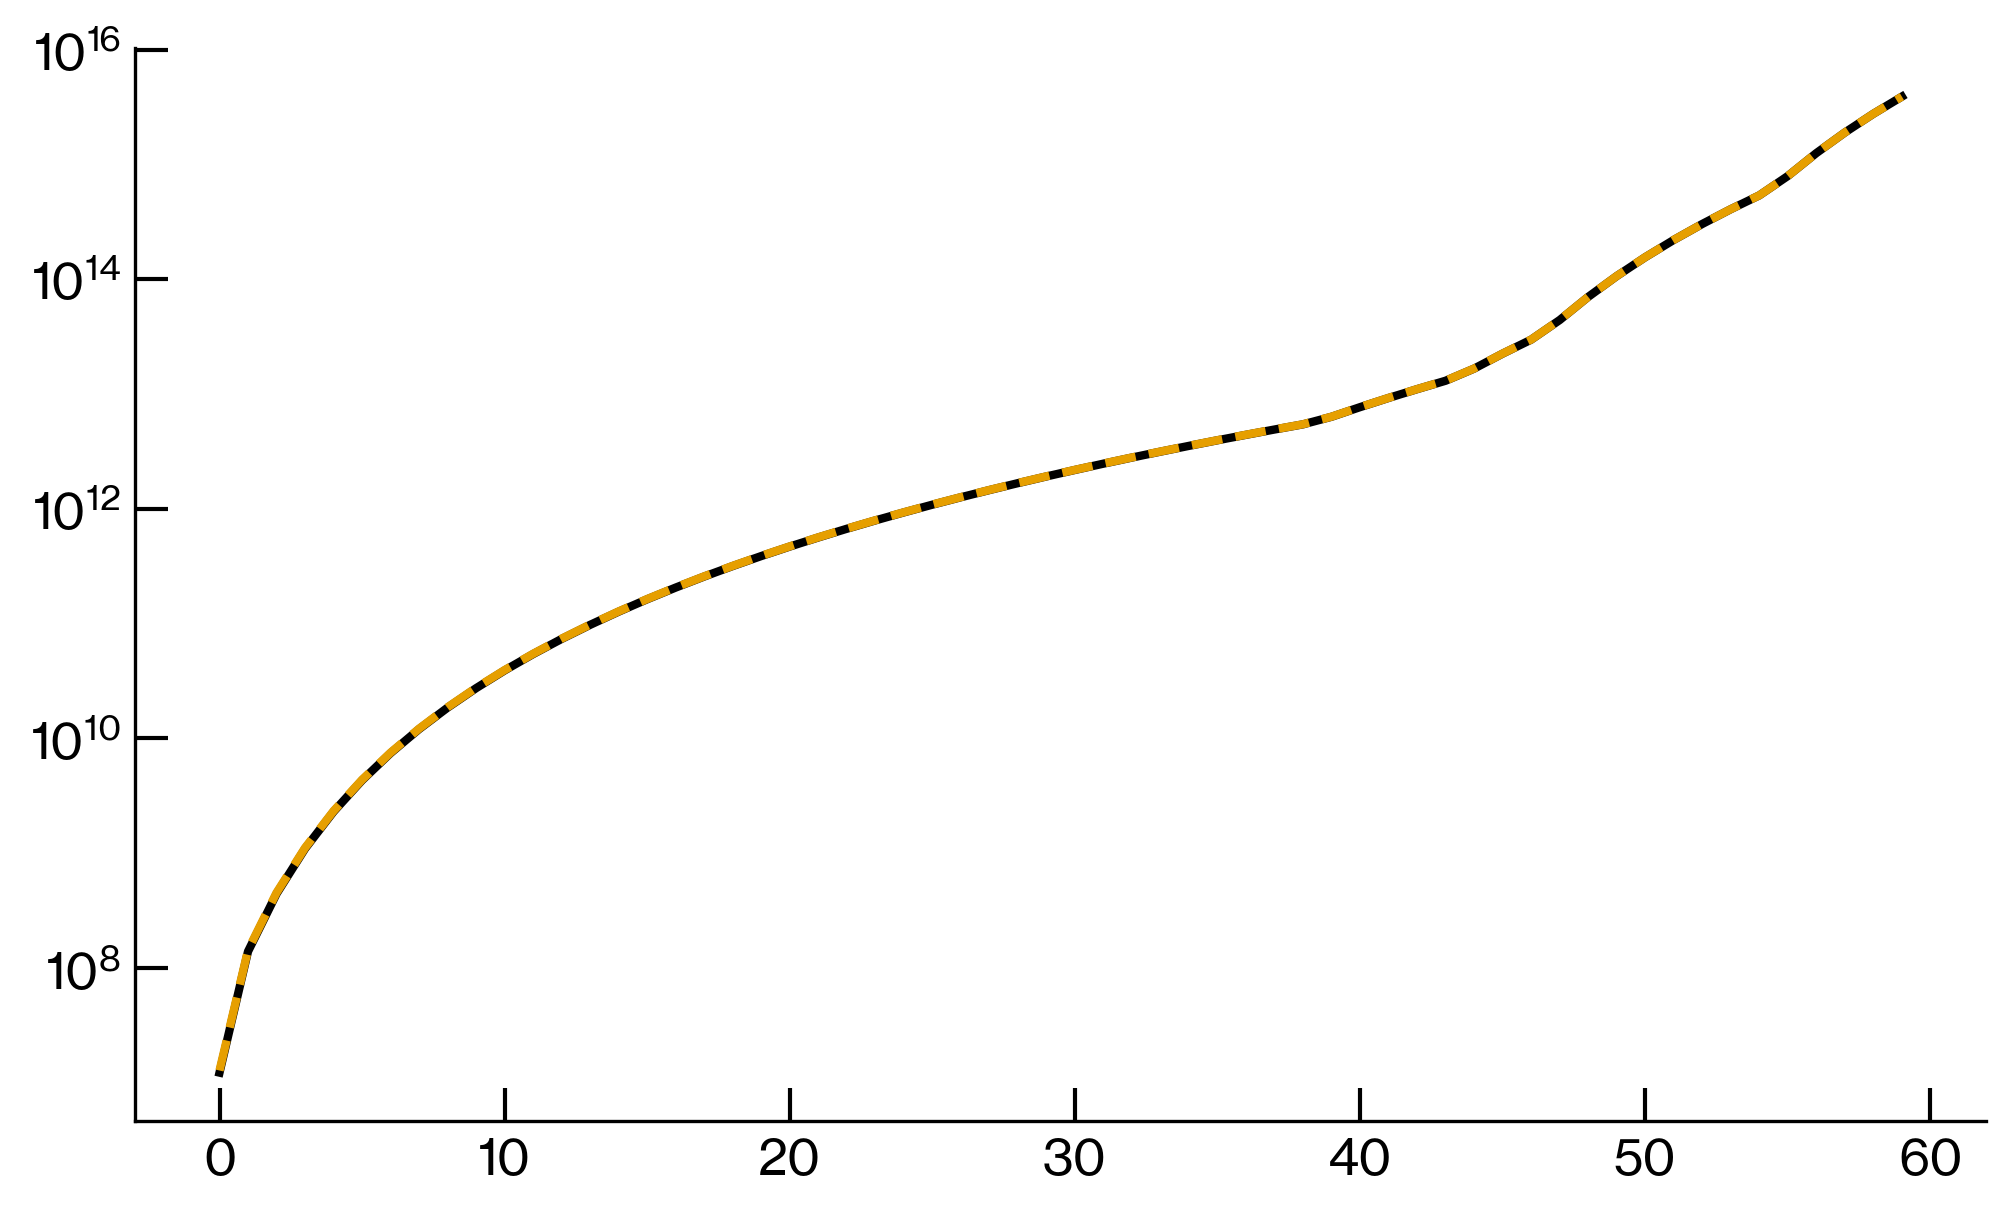

In [5]:
# test against dummy spectra
cl = l**2.1
ps = np.zeros(n_bins)
for ibin in range(n_bins):
    loc = np.where((l >= bin_lo[ibin]) & (l <= bin_hi[ibin]))
    ps[ibin] = (cl[loc] * fac[loc]).mean()
plt.plot(Pbl @ cl)
plt.plot(ps, "--")
plt.yscale("log")

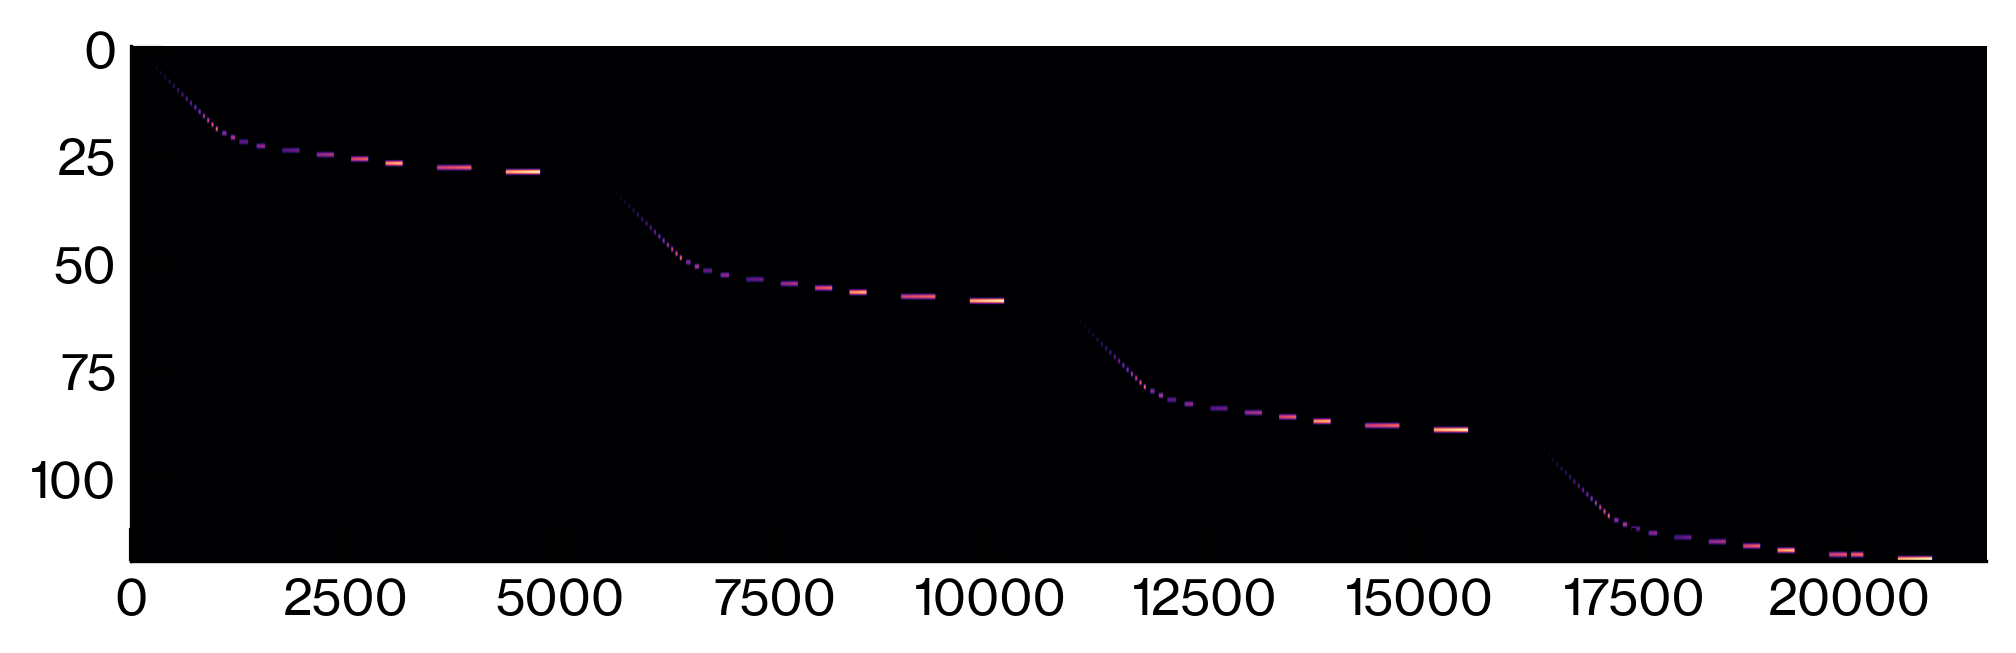

In [6]:
import scipy.linalg

Pbl_pol =  scipy.linalg.block_diag(Pbl, Pbl, Pbl, Pbl)

plt.imshow(Pbl_pol[::2, ::2], aspect=50)

In [7]:
from pspy import so_mcm

In [8]:
spin_pairs = ["spin0xspin0", "spin0xspin2", "spin2xspin0", "spin2xspin2"]
mbb_inv, Bbl = so_mcm.read_coupling(prefix=f"{base_dir}/mcms/{na}x{nb}", spin_pairs=spin_pairs)

In [9]:
spectra

['TT', 'TE', 'TB', 'ET', 'BT', 'EE', 'EB', 'BE', 'BB']

In [10]:
# dg = mbb_inv['spin2xspin2'][::8, ::8]
# plt.imshow(np.log10(np.abs(dg)))

In [11]:
spectra

['TT', 'TE', 'TB', 'ET', 'BT', 'EE', 'EB', 'BE', 'BB']

In [12]:
Pbl_pol =  scipy.linalg.block_diag(Pbl, Pbl, Pbl, Pbl)

In [13]:
M00 = Pbl @ mbb_inv['spin0xspin0']
M02 = Pbl @ mbb_inv['spin0xspin2']
M20 = Pbl @ mbb_inv['spin2xspin0']
M22 = Pbl_pol @ mbb_inv['spin2xspin2']

Mbl = scipy.linalg.block_diag(M00, M02, M02, M20, M20, M22)

In [14]:
from pspipe_utils import kspace
from pspy import so_map

apply_kspace_filter = d["apply_kspace_filter"]
kspace_tf_path = d["kspace_tf_path"]
surveys = d["surveys"]
spec_name = f"{na}x{nb}"

if kspace_tf_path == "analytical":
    arrays, templates, filter_dicts =  {}, {}, {}
    for sv in surveys:
        arrays[sv] = d[f"arrays_{sv}"]
        if apply_kspace_filter == True: filter_dicts[sv] = d[f"k_filter_{sv}"]
        templates[sv] = so_map.read_map(str(base_dir / d[f"window_T_{sv}_{arrays[sv][0]}"]))
    kspace_transfer_matrix = kspace.build_analytic_kspace_filter_matrices(
        surveys, arrays, templates, filter_dicts, binning_file, lmax)[spec_name]
else:
    kspace_transfer_matrix = np.load(f"{kspace_tf_path}/kspace_matrix_{spec_name}.npy", allow_pickle=True)
    # _, TE_corr = so_spectra.read_ps(f"{kspace_tf_path}/TE_correction_{spec_name}.dat", spectra=spectra)

inv_kspace_mat = np.linalg.inv(kspace_transfer_matrix)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [19]:
spec_name = f"{na}x{nb}"
inv_kspace_mat = np.linalg.inv(kspace_transfer_matrix)

In [20]:
Finv_Mbl = inv_kspace_mat @ Mbl

/tmp/ipykernel_850787/2702322320.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Finv_Mbl[:, ::4])), aspect=25)


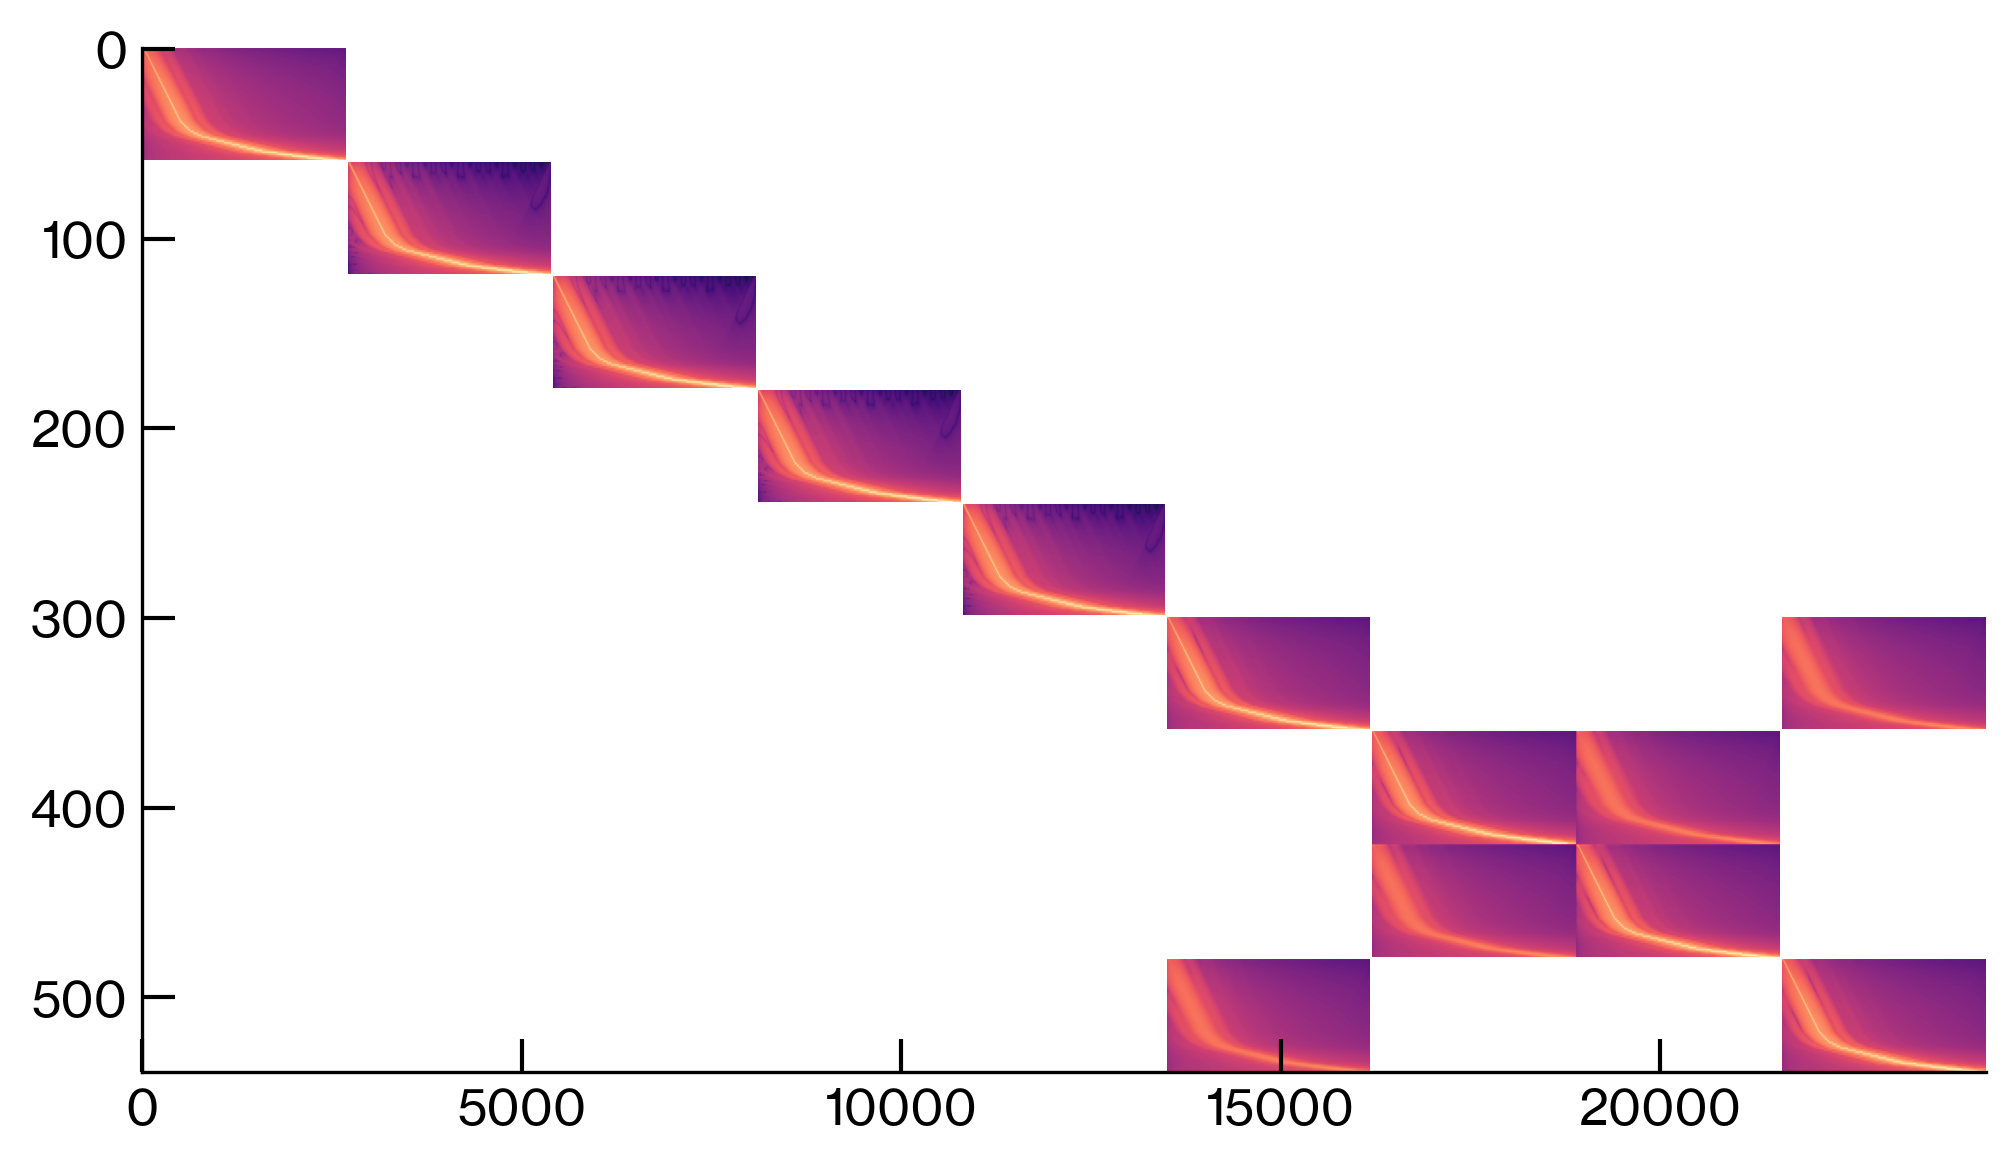

In [21]:
plt.imshow(np.log10(np.abs(Finv_Mbl[:, ::4])), aspect=25)

In [25]:
from pspy import so_spectra
s1, s2 = 0, 1
specdir = "spectra"
l, pCl = so_spectra.read_ps(base_dir / specdir / f"pseudo_{na}x{nb}_{s1}{s2}.dat", spectra=spectra)
lb_ref, Cb_ref = so_spectra.read_ps(base_dir / specdir / f"Dl_{na}x{nb}_{s1}{s2}.dat", spectra=spectra)

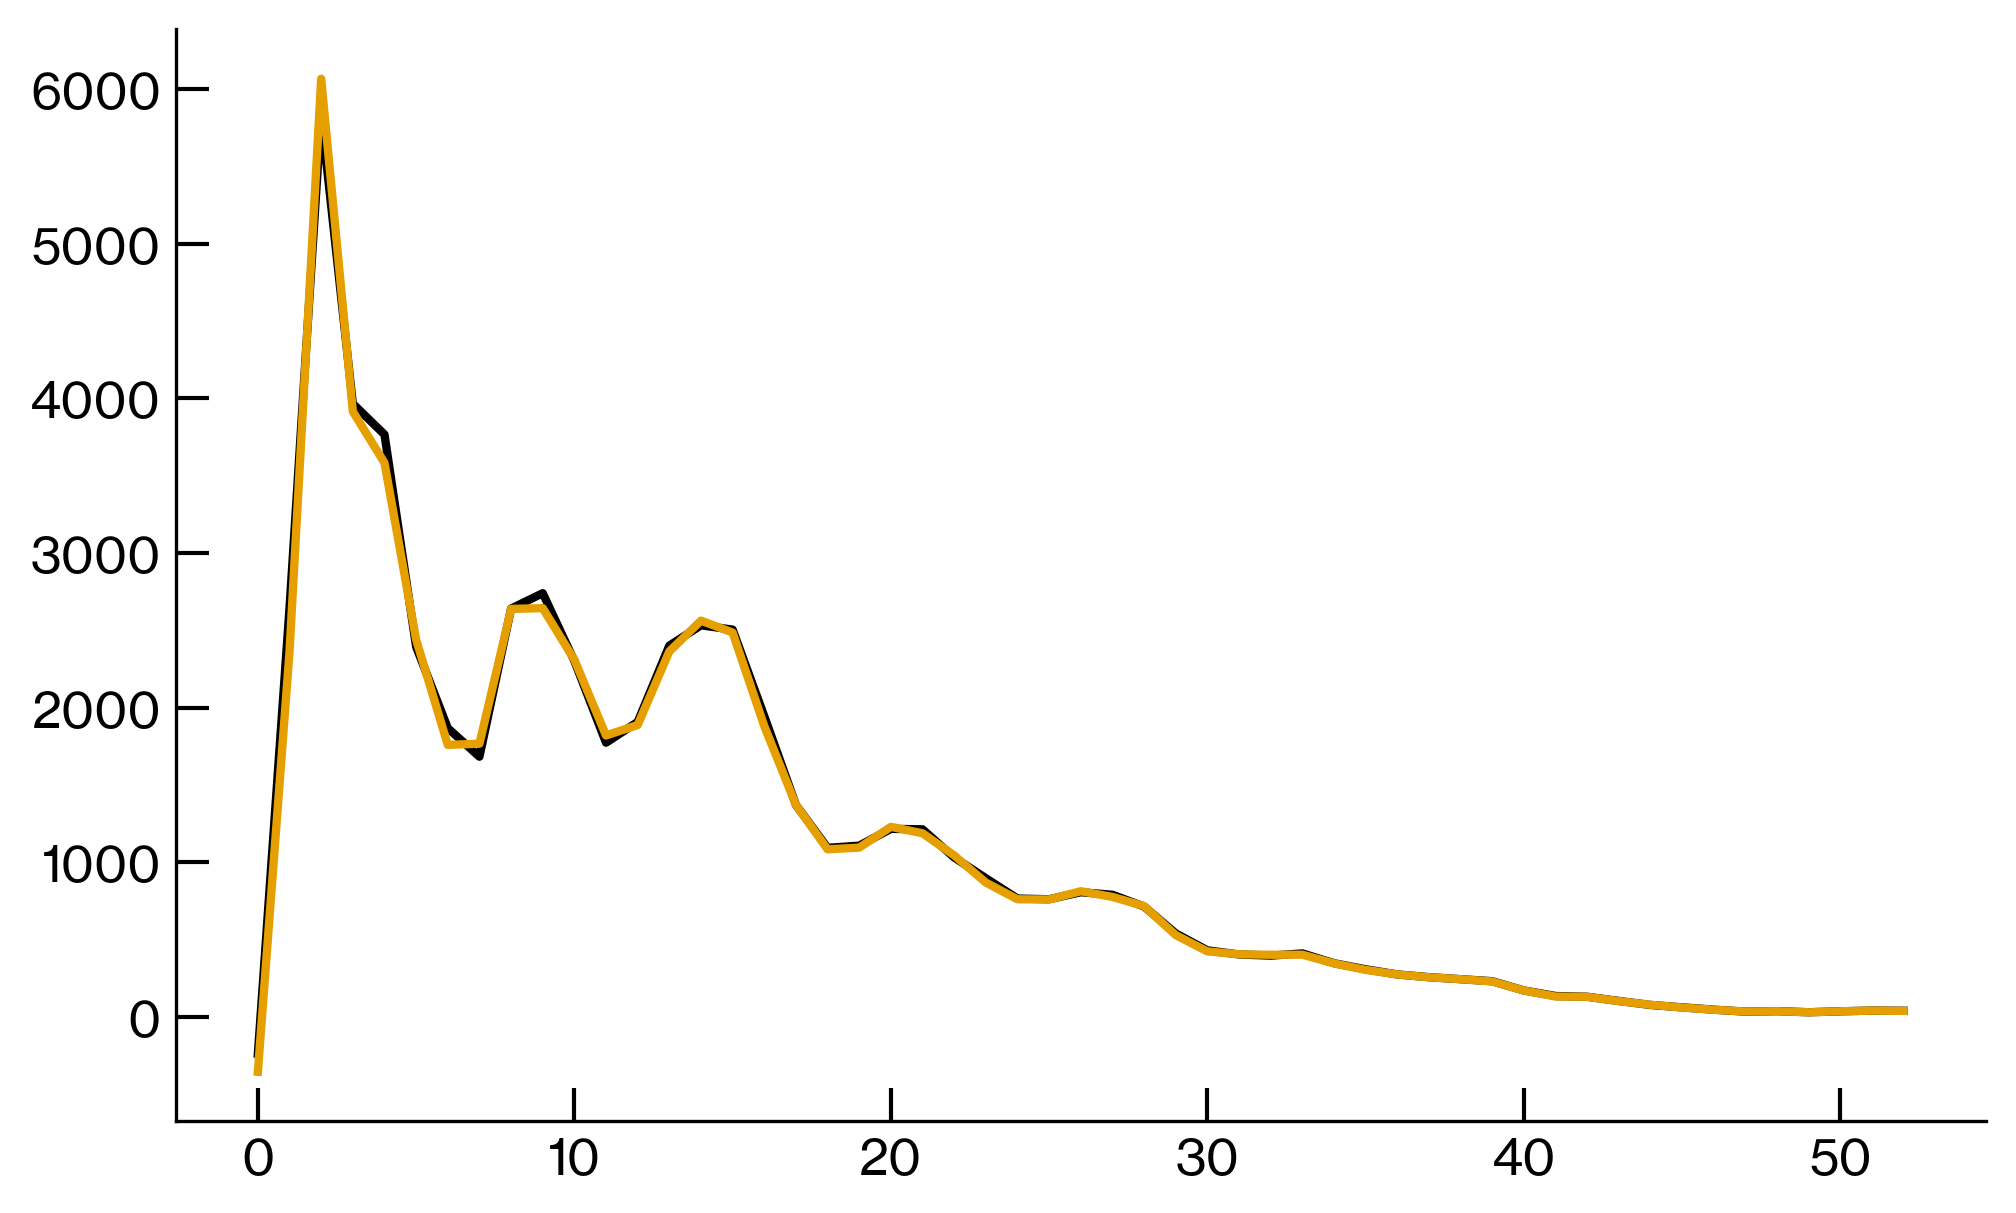

In [29]:
def makevec_ell(cl_dict, spectra, lmax):
    return np.hstack([cl_dict[s][2:lmax] for s in spectra])

def makevec_binned(cl_dict, spectra):
    return np.hstack([cl_dict[s][:] for s in spectra])

pCl_vector = makevec_ell(pCl, spectra, lmax)
pCb_ref_vector = makevec_binned(Cb_ref, spectra)

plt.plot((Finv_Mbl @ pCl_vector)[:53])
plt.plot(pCb_ref_vector[:53])
# plt.yscale("log")

In [ ]:
# inv_kspace_mat = np.linalg.inv(kspace_filter_matrix)
# vec = []
# for f in spectra:
#     vec = np.append(vec, ps[f])
# vec = np.dot(inv_kspace_mat, vec)
# ps = so_spectra.vec2spec_dict(n_bins, vec, spectra)

# # kspace_transfer_matrix[f"{sv1}_{ar1}x{sv2}_{ar2}"]

In [ ]:

# from pspy import pspy_utils, so_dict, so_map, so_mcm, so_mpi, so_spectra
# from pspipe_utils import kspace, log
# log = log.get_logger(**d)

In [ ]:
# plt.plot(lb ,TE_corr['dr6_pa6_f150xdr6_pa6_f150']['TE'])

In [ ]:
plt.imshow(np.log10(np.abs(kspace_transfer_matrix) + 1e-30))

In [ ]:
# TE_corr

In [ ]:
300 / n_bins